# DLT - Method without Normalization:-

## Libraries needed:-

In [1]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pandas as pd
from scipy import linalg

%matplotlib inline
np.set_printoptions(suppress=True)

## Reading World and Image coordinates :-

In [2]:
def read_coordinates():
    data = pd.read_excel("Coordinates.xlsx")
    display(data)
    
    #WORLD COORDINATES
    X = np.array(data['X'])
    Y = np.array(data['Y'])
    Z = np.array(data['Z'])
    
    #IMAGE PIXEL COORDINATES
    x = np.array(data['x'])
    y = np.array(data['y'])
    
    # LIST OF WORLD PTS AND CORRESPONDING PIXEL PTS
    world_pts = []
    pixel_pts = []
    
    for i in range(len(X)):
        world_pts.append([X[i], Y[i], Z[i]])
        pixel_pts.append([x[i], y[i]])

    return world_pts, pixel_pts

##  Dummy Function - to avoid compilation errors:

In [3]:
#Function will return the Actual Input Data, without doing any Transformation.
#Purpose is to maintain uniformity of CalibrateDLT function for both Normalized as well as UnNormalized data.

def Normalize(data):
    """
    Isotropic point normalization
    
    Returns:
    Homgenous coordinates, Transformation matrix
    """
    num_pts = len(data)
    dim = len(data[0])
    data = np.asarray(data)
    
    #Find mean/centroid of the data and normalize avergae distance
    mu = np.mean(data, axis=0)
    avg_dist = np.mean(np.sqrt(np.sum(np.square(data - mu))))
    scale = np.sqrt(dim)/avg_dist
    
    T = np.zeros([dim, dim])
    if dim == 2:
        T = np.diag([scale, scale, 1])
        T[0,2] = -scale*mu[0]
        T[1,2] = -scale*mu[1]
    elif dim == 3:
        T = np.diag([scale, scale, scale, 1])
        T[0,3] = -scale*mu[0]
        T[1,3] = -scale*mu[1]
        T[2,3] = -scale*mu[2]
    
    #Homogeneous coordinate
    col = np.ones([num_pts, 1])
    tr_data = np.append(data, col, axis=1)
    
    #After scaling
    tr_data = tr_data[:,0:dim]
    
    #Not normalizing so returning identity matrix instead
    T = np.identity(dim+1)
    # Return transformed data and transformation matrix
    return tr_data, T

## Function to Estimate (3x4) Projection Matrix:-

In [4]:
def CalibrateDLT(world_pts, pxl_pts):
    """
    Estimates  the  3  ×  4  projection  matrix  P  
    and  then  decompose  it  into  theintrinsics and extrinsics. 
    """
    num_pts = len(world_pts)
    
    world_pts = np.asarray(world_pts)
    pxl_pts = np.asarray(pxl_pts)
    
    world_pts_normalized, T_world = Normalize(world_pts)
    pxl_pts_normalized, T_pxl = Normalize(pxl_pts)
    
    #First, Find projection matrix
    A = []
    
    for i in range(num_pts):
        X, Y, Z = world_pts_normalized[i, 0], world_pts_normalized[i, 1], world_pts_normalized[i, 2]
        x, y = pxl_pts_normalized[i, 0], pxl_pts_normalized[i, 1]
        r1 = [X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x]
        r2 = [0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y]
        
        A.append(r1)
        A.append(r2)
    
    # Convert A to array
    A = np.asarray(A) 
    
    # Am = 0
    # Perform SVD to find the eigenvector with smallest eigen value,
    # where 'm' is right singular vector of A i.e. V corresponding to singular value zero
    # U: Left singular vector
    # S: Singular values (equivalent to eigenvalue)
    # V: Right singular vector
    #
    # There are total 4 zero singular values. Try vector corresponding to all 4
    U, S, V = np.linalg.svd(A)
    
    #Camera Projection matrix
    #Choose the one which gives smallest error
    #Also, see if scaling is needed later
    H = V[-1,:]/V[-1, -1] #Is dividing by V[-1, -1] correct
    H = H.reshape(3, 4)
    
    #Denormalize
    #https://web.archive.org/web/20150929063658/http://www.ele.puc-rio.br/~visao/Topicos/Homographies.pdf
    #H = inv(T_pixel)*H'*T_world
    H = np.matmul( np.matmul( np.linalg.pinv(T_pxl), H ), T_world )
    H = H/H[-1, -1]
    
    print("Camera Projection Matrix: \n")
    print(H)
    
    #Mean error of the DLT (mean residual of the DLT transformation in units of camera coordinates):
    estimated_pt = np.dot( H, np.concatenate( (world_pts.T, np.ones((1, world_pts.shape[0]))) ) ) 
    estimated_pt = estimated_pt / estimated_pt[2, :] 
    estimated_pt = np.asarray(estimated_pt.T)
    
    err = np.sqrt( np.mean(np.sum( (estimated_pt[:,0:2] - pxl_pts)**2, 1)) ) 
    print("\nError: ", err)
    
    #Plot points
    f = plt.figure()
    plt.scatter(pxl_pts[:,0], pxl_pts[:,1], label="Pixel points")
    plt.scatter(estimated_pt[:,0], estimated_pt[:,1], color='red', label='Estimated points')
    plt.legend()
    plt.show()
    
    return H, err, pxl_pts, estimated_pt

## Extracting Intrinsic and Extrinsic Parameters from Projection Matrix:-

In [5]:
def Do_RQ_decomposition(H):
    """
    Input: Camera projection matrix
    Outout: Intrinsic and extrinsic parameter
    """
    
    #Find K (Calibration matrix - intrinsic) and R (Rotation matrix)
    #Details of the procedure: https://drive.google.com/file/d/1CdTH1v94yW28LfozrfOCc3it-KH8OrSS/view?usp=sharing
    #Q = Orthogonal matrix (Rotation matrix, Extrinsic parameter), 
    #R = Upper triangular matrix (Camera Calibration matrix, Intrinsic parameter)
    R, Q = linalg.rq(H[0:3, 0:3]) #Consider decomposition of 3x3 matrix only
    Rot_Mat = Q
    K = R
    #K = K/K[-1,-1]
    print("\n Rotation Matrix: \n", Rot_Mat)
    print("\n Camera calibration matrix: \n", K/K[-1,-1])
    
    #Find t (translation matrix, extrinsic matrix) from known K
    t = np.matmul(np.linalg.inv(K), H[:,3])
    print("\n Translation matrix: \n", t)
    
    #Camera center in world coordinate system
    CW = -np.matmul(np.linalg.inv(Rot_Mat), t.reshape(3,1))
    print("\n Camera center: \n", CW)
    
    K = K/K[-1,-1]
    #Principal point
    print("\n Principal point (in pixels): \n", K[0:2,2])
    
    #Skewness
    THETA = np.arctan(-K[0,0]/K[0,1])*180/np.pi
    print("\n Skewness (θ): \n", np.abs(90 - THETA))
    
    #Alpha and Beta
    print("\n Alpha: \n", np.absolute(K[0,0]))
    print("\n Beta: \n", np.absolute(K[1,1]/np.sin(np.deg2rad(THETA))))

# Main Script:-

,X,Y,Z,x,y
0,10.2,0.0,24.0,966,609
1,3.4,0.0,20.6,1402,812
2,13.6,0.0,13.8,795,1493
3,0.0,0.0,13.8,1575,1238
4,6.8,0.0,10.4,1277,1578
5,10.2,0.0,3.6,1066,2057
6,0.0,6.8,24.0,1969,585
7,0.0,13.6,20.6,2395,1006
8,0.0,10.2,13.8,2092,1462
9,0.0,6.8,7.0,1869,1800


Camera Projection Matrix: 

[[ -60.18208512   14.9989161   -13.76421902 1567.27563795]
 [  -2.02587577   -0.66841696  -65.43383545 1978.53588668]
 [  -0.01264888   -0.01366385   -0.00938709    1.        ]]

Error:  13.522683437421177


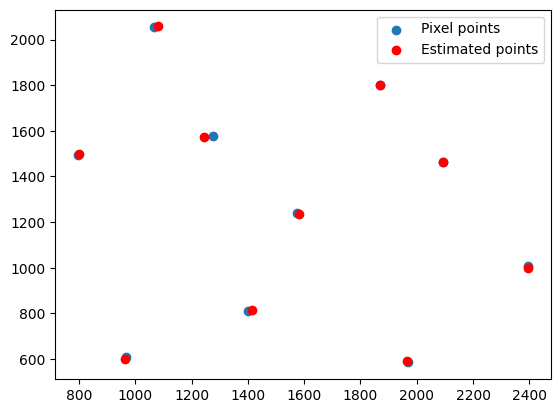


 Rotation Matrix: 
 [[ 0.73920105 -0.67329454 -0.01600835]
 [-0.29260953 -0.34247937  0.8927976 ]
 [-0.60659828 -0.65527272 -0.4501735 ]]

 Camera calibration matrix: 
 [[-2607.16440411     8.84179263  1576.53966561]
 [    0.         -2762.18217549  1492.57769126]
 [    0.             0.             1.        ]]

 Translation matrix: 
 [ 0.14179097 -8.43714606 47.95666517]

 Camera center: 
 [[26.51682935]
 [28.63061322]
 [29.12375355]]

 Principal point (in pixels): 
 [1576.53966561 1492.57769126]

 Skewness (θ): 
 0.1943089811747285

 Alpha: 
 2607.164404113342

 Beta: 
 2762.1980596697144


In [6]:
world_pts, pxl_pts = read_coordinates()
H, err, original_pts, estimated_pts = CalibrateDLT(world_pts, pxl_pts)
Do_RQ_decomposition(H)

## Ploting Estimated points on Image:-

In [7]:
def draw_on_image(original_pts, estimated_pts):
    img = cv2.imread("./IMG_3718_Original.png")
    print("Success")
#     cv2.imshow('original image', img)
    cv2.waitKey(1000)
    img_org = img.copy()
    img_est = img.copy()

    for i in original_pts:
        center = (i[0], i[1])
        radius = 30
        color_of_marker = (0,0,255)
        cv2.circle(img_org, center, radius,color_of_marker,-1)
#     cv2.imshow('original image', img_org)
    cv2.imwrite("./ORIGINAL_INTEREST_POINTS_UNORMALIZED.jpg", img_org)
    cv2.waitKey(500)

    for i in estimated_pts:
        center = (int(np.rint(i[0])), int(np.rint(i[1])))
        #print(center)
        radius = 30
        color_of_marker = (0,255,0)
        cv2.circle(img_est, center, radius,color_of_marker, -1)
#     cv2.imshow('original image', img_est)
    cv2.imwrite("./ESTIMATED_POINTS_UNORMALIZED.jpg", img_est)
    cv2.waitKey(500)

    for i in estimated_pts:
        center = (int(np.rint(i[0])), int(np.rint(i[1])))
        #print(center)
        radius = 25
        color_of_marker = (0,255,0)
        cv2.circle(img_org, center, radius,color_of_marker, 10)
#     cv2.imshow('original image', img_org)
    cv2.imwrite("./ORIGINAL_ESTIMATED_POINTS_UNORMALIZED_COMPARED.jpg", img_org)
    cv2.waitKey(500)

In [8]:
draw_on_image(original_pts, estimated_pts)
%matplotlib inline

Success


## Final Comparision of Interest and Estimated points:-

Text(0.5, 1.0, 'Overlapping of Interest and Unormalized Estimated points')

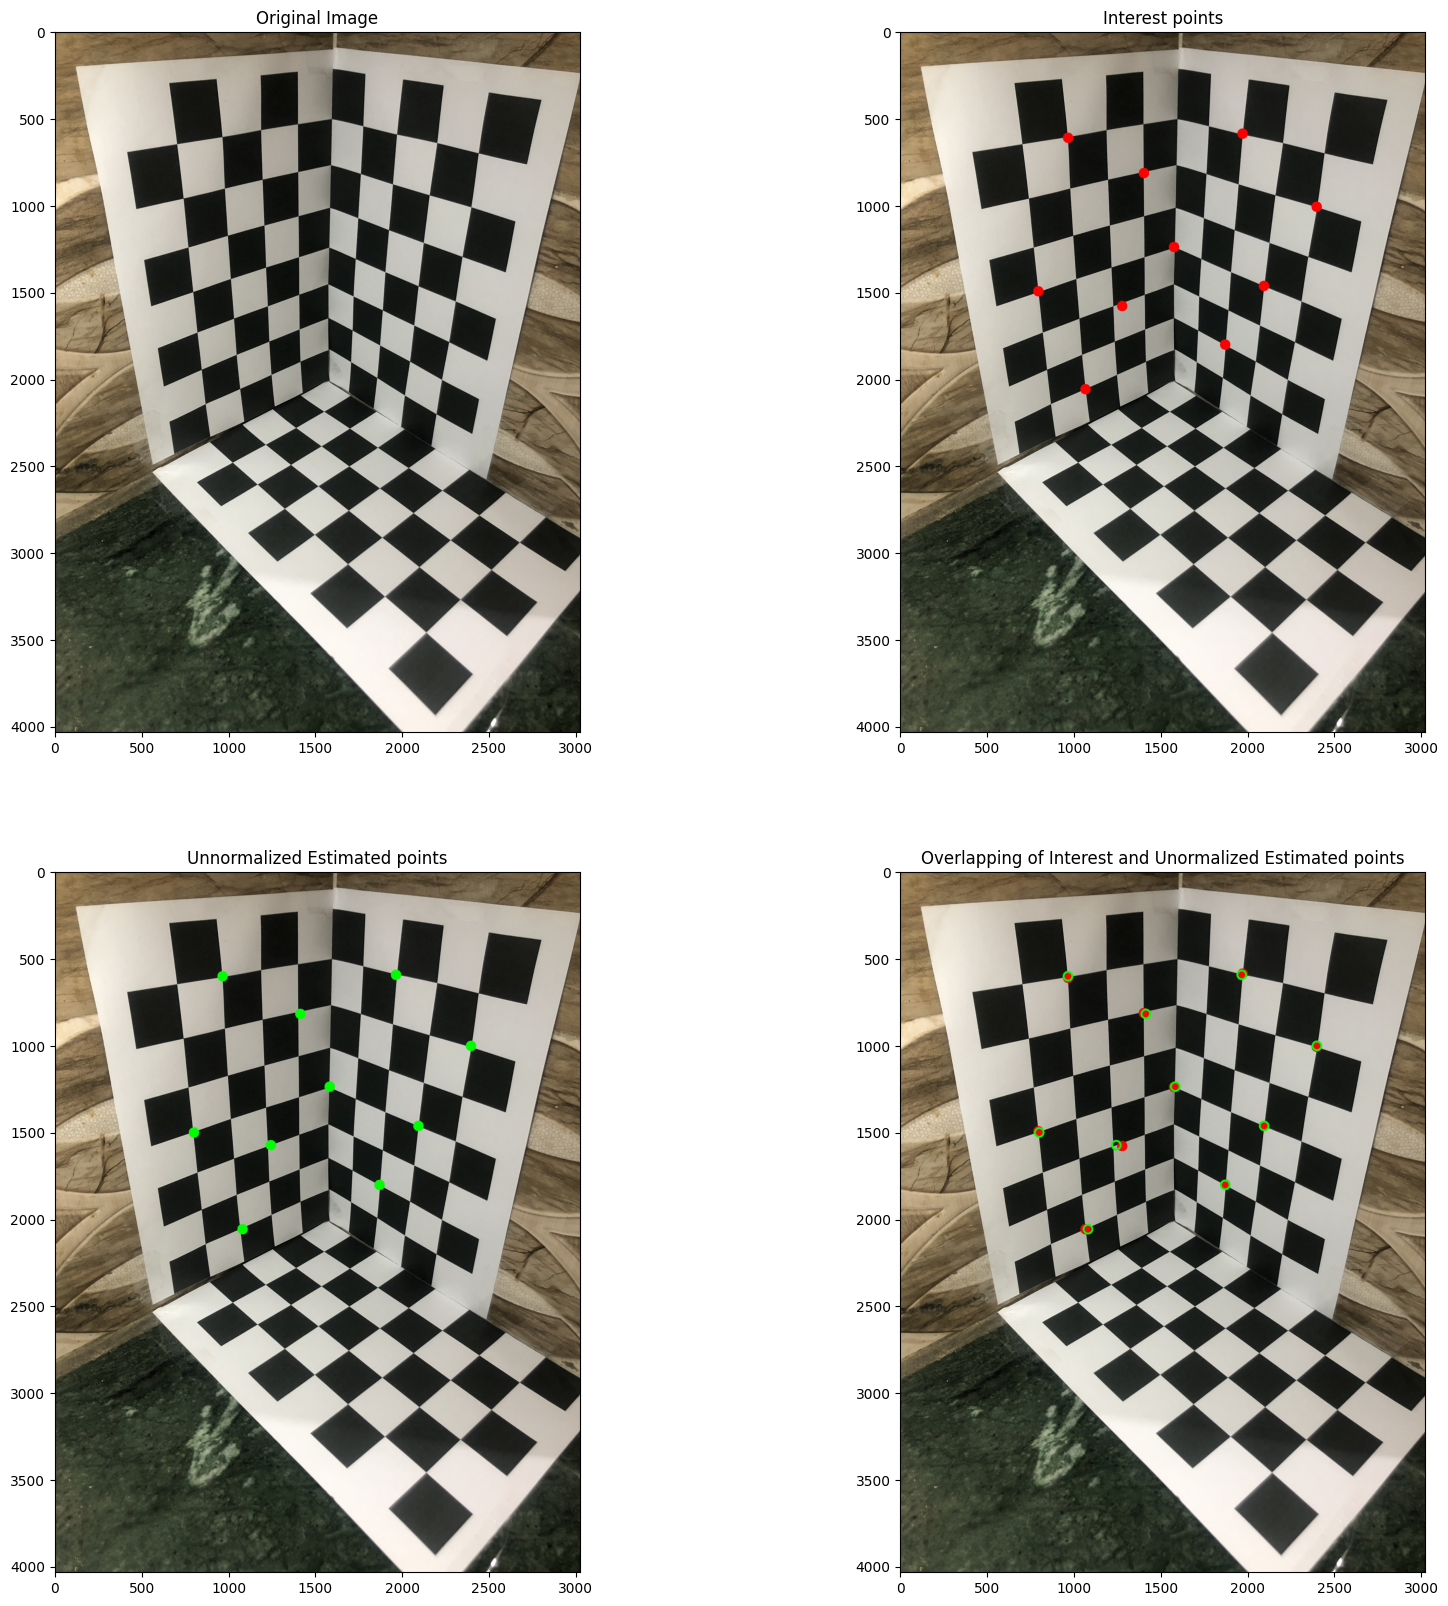

In [9]:
original_image = plt.imread("./IMG_3718_Original.png")
original_pts_image = plt.imread("./ORIGINAL_INTEREST_POINTS_UNORMALIZED.jpg")
estimated_pts_image = plt.imread("./ESTIMATED_POINTS_UNORMALIZED.jpg")
overlay_image = plt.imread("./ORIGINAL_ESTIMATED_POINTS_UNORMALIZED_COMPARED.jpg")

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(2,2,2)
plt.imshow(original_pts_image)
plt.title("Interest points")

plt.subplot(2,2,3)
plt.imshow(estimated_pts_image)
plt.title("Unnormalized Estimated points")

plt.subplot(2,2,4)
plt.imshow(overlay_image)
plt.title("Overlapping of Interest and Unormalized Estimated points")